<i>Alunos: Lucas Borges Pacheco e Lara Destefani</i>

### **Inventário de Emissões**

O inventário de emissões de poluentes atmosféricos é uma ferramenta utilizada para identificar e classificar diversas fontes de poluição, bem como quantificar os principais poluentes emitidos em uma determinada área de interesse e período de tempo. As informações do inventário podem ser inseridas em modelos númericos de dispersão de poluentes atmosféricos, permitindo estimar os impactos dessas emissões na concentração de poluentes na atmosfera. Dessa forma, o inventário desempenha um papel fundamental na gestão e preservação da qualidade do ar.

O objetivo deste estudo é analisar especificamente as emissões de **poluentes geradas pelo processo de fundição** realizadas pelas fontes estacionárias da empresa **Embraco**. A Embraco, integrante da Nidec Global Appliance, é uma referência global em tecnologia de refrigeração, atendendo tanto o segmento residencial quanto o comercial da cadeia do frio. A empresa adota uma abordagem estratégica para reduzir suas emissões de gases de efeito estufa (GEE) durante seu processo produtivo, centrada principalmente na redução do consumo energético.

**Bibliotecas utilizadas no estudo**

In [1]:
import os
import numpy
import pandas
import warnings
import scipy.stats
import statsmodels
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

##### **Fatores de Emissões**

O fator de emissão é uma medida que expressa a quantidade de poluente liberado na atmosfera por unidade de atividade poluidora. Neste estudo, os fatores de emissões serão expressos em termos de massa de poluente emitido por tonelada de ferro fundido.

A Embraco Fundição, situada em Joinville, Santa Catarina, destaca-se como uma empresa especializada na fabricação de componentes de compressores para refrigeração. Segundo dados do Programa Brasileiro GHG Protocol de 2017, o inventário de emissões de gases de efeito estufa da empresa revela que a fundição processa cerca de aproximadamente **52 mil toneladas de peças fundidas anualmente**. Desse total, aproximadamente 94% são destinados às unidades da própria Embraco <i>(https://x.gd/zOIK0)</i>. Os escopos abordados por esse inventário são:
- Escopo 1: Abrange emissões diretas de GEE originadas de combustão estacionária e fugitivas sob propriedade ou controle direto da fundição.
- Escopo 2: Abrange emissões indiretas de GEE resultantes da aquisição de energia por parte da fundição.

O presente estudo irá abordar a emissão de poluentes atmosféricos originadas pelo processo de combustão estacionária. Embora não tenhamos acesso a informações específicas sobre os metais exatos utilizados pela Embraco Fundição em Joinville, é razoável presumir que eles empregam uma variedade de metais comuns na indústria de fundição, tais como ferro fundido, alumínio, cobre e ligas metálicas específicas para atender às necessidades de produção de compressores de refrigeração. Portanto, optamos por utilizar o **subcapítulo 10** do **capítulo 12** (Gray Iron Foundries) como metodologia para estimar as emissões da empresa e seus respectivos fatores de emissão.

**Importação da tabela de fatores de emissão**

Os fatores de emissão são expressos em <i>kilogramas de poluente por tonelada de ferro cinzento fundido</i>.

In [2]:
root = os.path.dirname(os.getcwd()).replace('\\','/')
filepath_fe = f'{root}/tabelas/FE/chpt_12_10.csv'

emission_factor = pandas.read_csv(filepath_fe,delimiter=';')
emission_factor = emission_factor.reset_index(drop=True).set_index('Processos').fillna(0)
emission_factor

,PM,CO,NO3,COVs
Processos,,,,
Forno elétrico a arco,6.30,19.0,0.3,0.15
Aquecimento de sucata e carga,0.10,0.0,0.0,0.00
Tratamento com magnésio,0.20,0.0,0.0,0.00
Limpeza e finalização,0.05,0.0,0.0,0.00
Fabricação e cozimento de núcleo,0.60,0.0,0.0,0.00


**Obs**: Devido a falta de acesso à informações da empresa, considerou-se apenas um tipo de forno, o Forno Elétrico a Arco.

**Qual o processo que gera mais poluente?**

A fundição de ferro é um processo industrial que envolve várias etapas, desde a preparação da matéria-prima até a produção final do produto. A etapa que gera mais poluentes atmosféricos é o **processo de fusão do minério de ferro em um forno**, emitidos principalmente devido à queima de combustíveis utilizados para aquecer o forno a altas temperaturas. Os fornos elétricos a arco, como é o nosso caso, são geralmente considerados uma opção mais limpa em comparação com os altos-fornos tradicionais na produção de ferro.

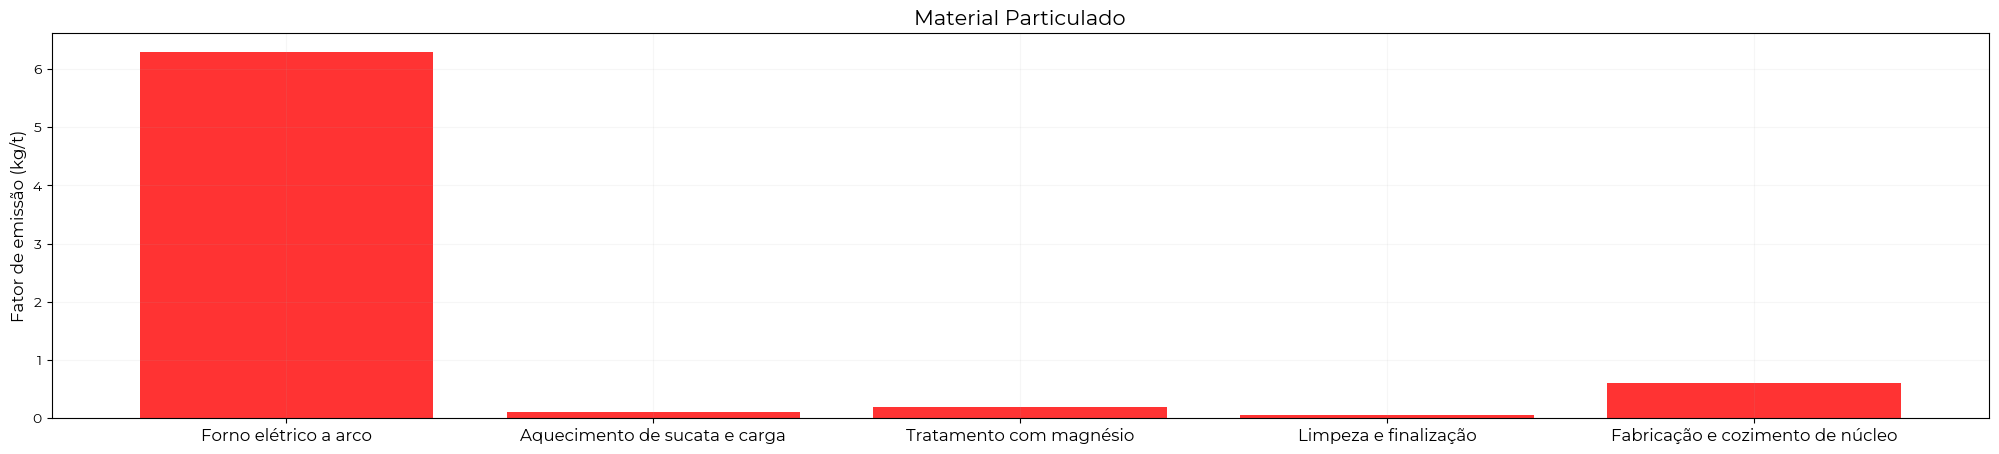

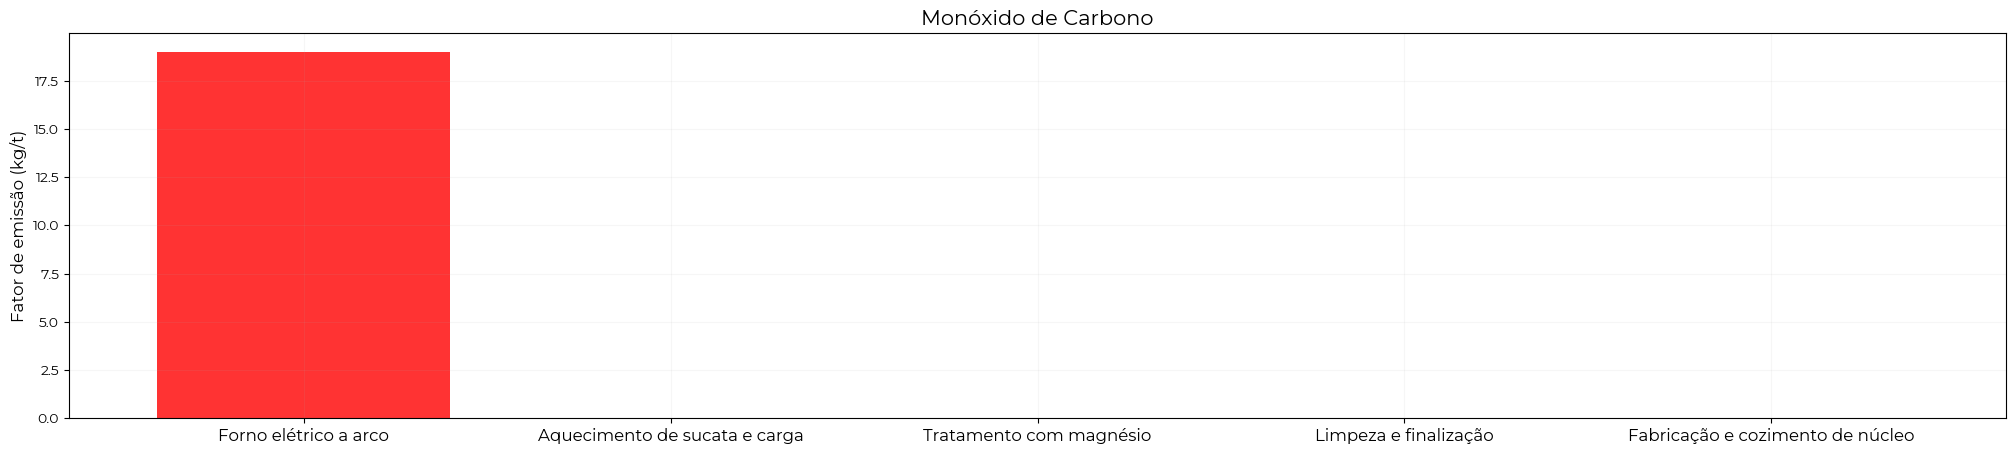

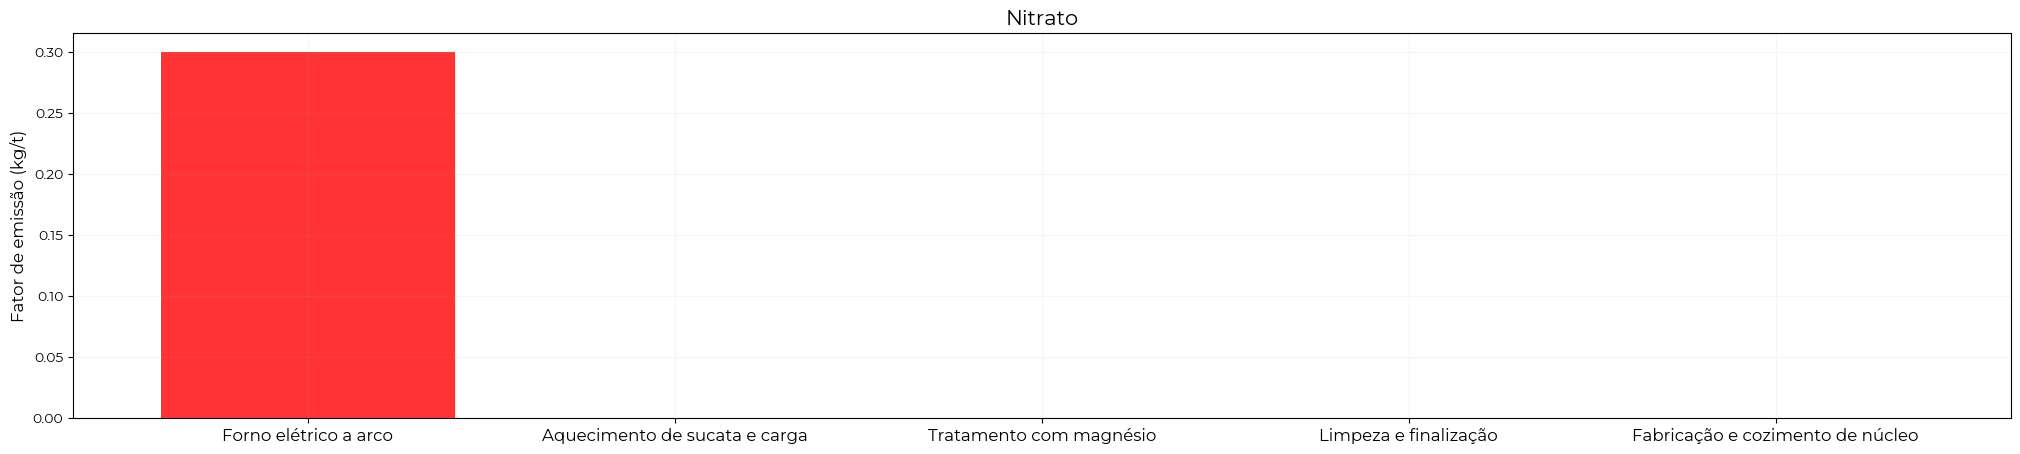

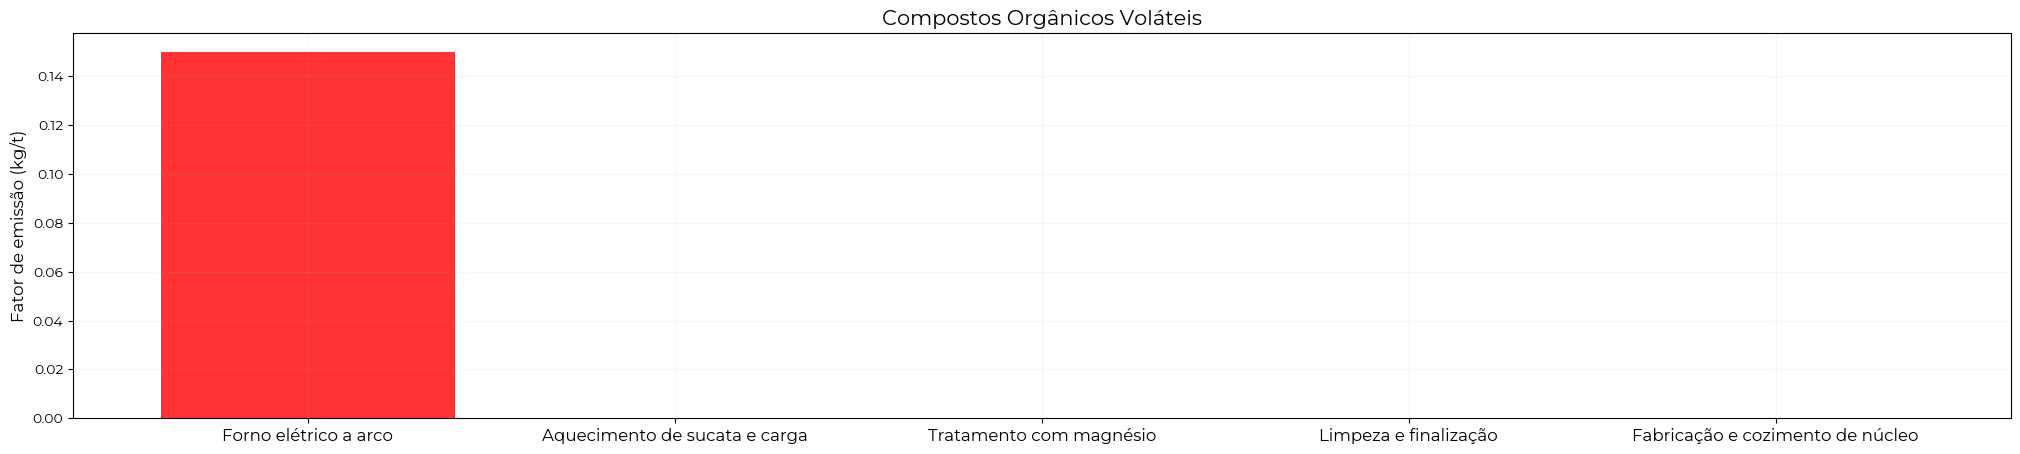

In [3]:
translate = {'PM':'Material Particulado','CO': 'Monóxido de Carbono', 'NO3':'Nitrato', 'COVs':'Compostos Orgânicos Voláteis'}
poluentes = list(emission_factor.columns)
for i in range(len(poluentes)):
        plt.rc('font',family='Montserrat')
        plt.figure(figsize=(25,5))
        plt.bar(emission_factor.index,emission_factor[f'{poluentes[i]}'], color='red',alpha=0.8)
        plt.title(translate[list(emission_factor.columns)[i]],fontsize=15)
        plt.xticks(fontsize=12)
        plt.ylabel('Fator de emissão (kg/t)',fontsize=12)
        plt.xticks(numpy.arange(len(emission_factor)), list(emission_factor.index)) 
        plt.grid(alpha=0.1)
        plt.show()

##### **Taxa de atividade**

A Associação Brasileira de Fundição (ABIFA) descreve brevemente o estado geral do setor de fundição ao longo do ano, incluindo tendências econômicas, desafios enfrentados pela indústria, e qualquer evento significativo que possa ter impactado o mercado. Portanto, utilizou-se dos boletins da ABIFA do ano 2023 para a criação da sazonalidade mensal (https://abifa.org.br/site/indices-setoriais/).

**Produção de ferro fundido no Brasil, em 2023.**

In [4]:
#Dicionário para armazenar as informações dos boletins mensais
summary = {"Mês": ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro", "Anual"],
    "Ferro (t)": [144125, 150748, 183109, 167706, 182088, 177436, 165751, 184974, 174231, 166177, 167079, 140111, 2003535],
    "Ferro (%)": []}

#Cálculo da porcentagem de cada mês em relação a produção total do setor
for i in range(len(summary['Ferro (t)'])):
    summary['Ferro (%)'].append(100*summary['Ferro (t)'][i]/summary['Ferro (t)'][-1])

summary = pandas.DataFrame(summary)
summary

,Mês,Ferro (t),Ferro (%)
0,Janeiro,144125,7.193535
1,Fevereiro,150748,7.524101
2,Março,183109,9.139296
3,Abril,167706,8.370505
4,Maio,182088,9.088336
5,Junho,177436,8.856147
6,Julho,165751,8.272928
7,Agosto,184974,9.232382
8,Setembro,174231,8.696180
9,Outubro,166177,8.294190


**Sazonalidade mensal de fundição da Embraco**

Como citado anteriormente, a empresa processa cerca de aproximadamente **52 mil toneladas de peças fundidas anualmente**. As porcentagens indicadas na tabela anterior serão utilizadas para calcular a produção mensal de ferro fundido da Embraco ao longo do ano de 2023, aplicando-as à sua produção anual.

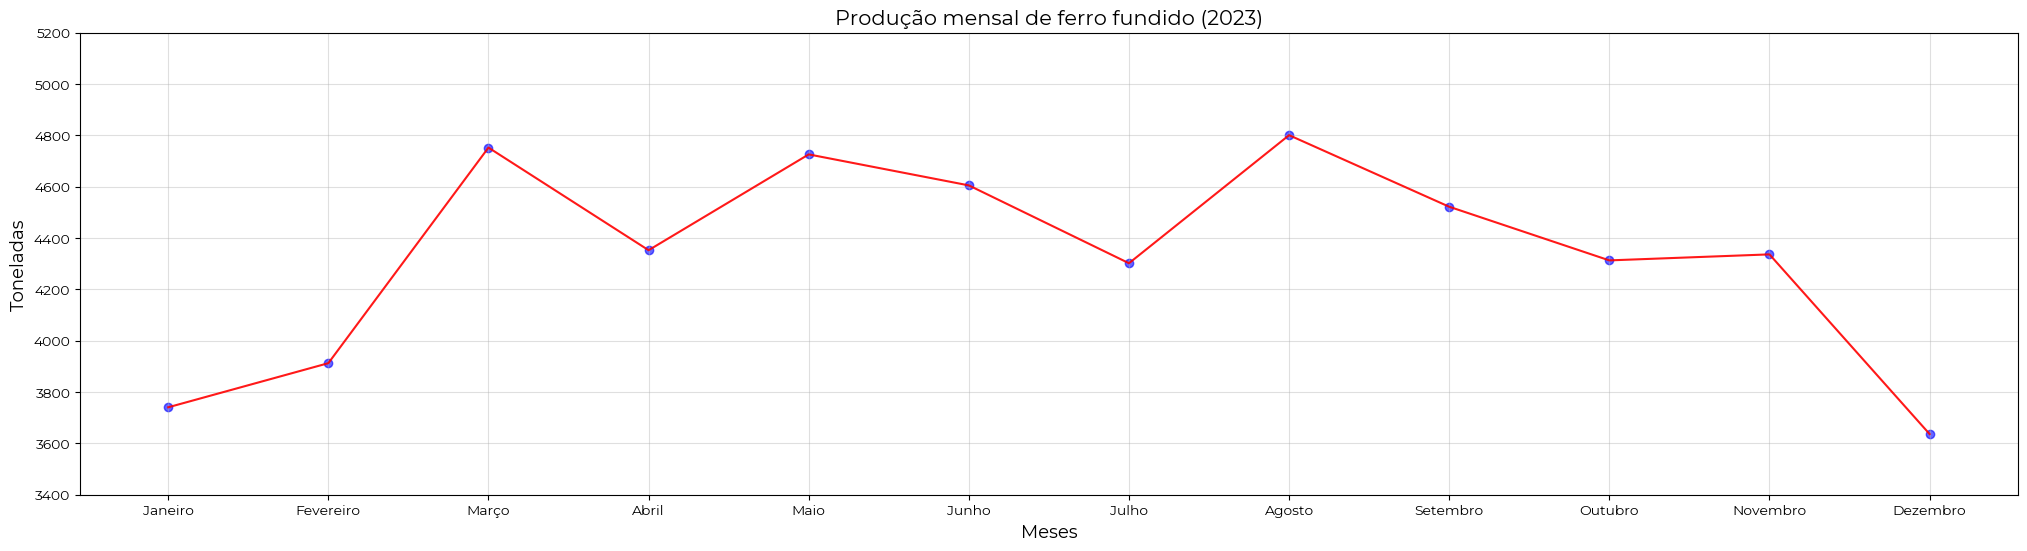

,Mês,Ferro (t)
0,Janeiro,3740.638422
1,Fevereiro,3912.532599
2,Março,4752.434073
3,Abril,4352.662669
4,Maio,4725.934910
5,Junho,4605.196316
6,Julho,4301.922352
7,Agosto,4800.838518
8,Setembro,4522.013341
9,Outubro,4312.978810


In [25]:
annual_production = 52000
monthly_production = {"Mês": ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"],"Ferro (t)": []}

for i in range(len(summary)-1):
    monthly_production['Ferro (t)'].append(annual_production*summary['Ferro (%)'][i]/100)

monthly_production = pandas.DataFrame(monthly_production)

#Plotagem do gráfico
plt.figure(figsize=(25,6))
plt.plot(monthly_production.Mês,monthly_production['Ferro (t)'],color='red',alpha=0.9,linewidth=1.5)
plt.scatter(monthly_production.Mês,monthly_production['Ferro (t)'],color='blue',alpha=0.6, label='Dados hipotéticos')
plt.title('Produção mensal de ferro fundido (2023)', fontsize=15)
plt.xlabel('Meses', fontsize=13)
plt.ylabel('Toneladas', fontsize=13)
plt.grid(alpha=0.4)
plt.ylim(bottom=3400,top=5200)
plt.show()
monthly_production

**Sazonalidade diária de fundição da Embraco**

A sazonalidade diária será modelada como uma variável aleatória distribuída normalmente. Para cada mês, a média da distribuição será calculada como o total de toneladas de ferro fundido produzido dividido pela quantidade de dias naquele mês. O desvio padrão da distribuição foi selecionado de forma a suavizar flutuações bruscas entre meses consecutivos, garantindo assim uma representação mais consistente e equilibrada no gráfico.

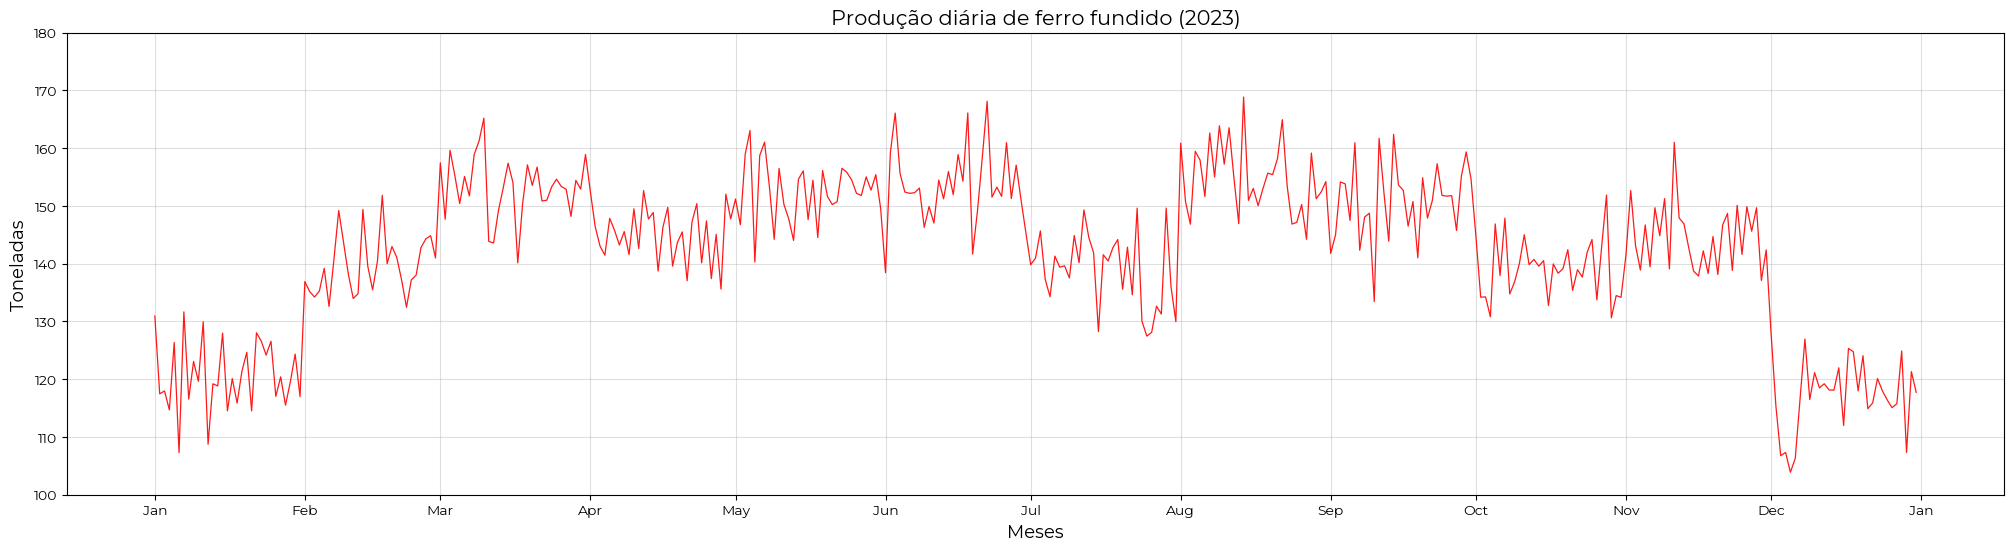

,Data,Ferro (t)
0,2023-01-01,130.934741
1,2023-01-02,117.464334
2,2023-01-03,117.967853
3,2023-01-04,114.685965
4,2023-01-05,126.362856
...,...,...
360,2023-12-27,115.770267
361,2023-12-28,124.892884
362,2023-12-29,107.323221
363,2023-12-30,121.316926


In [27]:
numpy.random.seed(1)
daily_production = numpy.arange(numpy.datetime64('2023-01-01'),numpy.datetime64('2024-01-01'),numpy.timedelta64(1,'D'))
daily_production = pandas.DataFrame(daily_production)
daily_production = daily_production.rename(columns={0:'Data'})
daily_production['Mês'] = daily_production.Data.dt.month
daily_production['Dia'] = daily_production.Data.dt.day

#Laço para aplicação da distribuição normal na sazonalidade diária
fluct = []
for i in range(12):
    atv_mensal = monthly_production['Ferro (t)'][i]
    dias = daily_production.groupby('Mês').size().values.tolist()[i]
    meann = atv_mensal/dias
    daily_values = numpy.random.normal(loc=meann, scale=6, size = dias)
    scale_factor = atv_mensal/numpy.sum(daily_values)
    fluct.extend(scale_factor*daily_values)

daily_production['Ferro (t)'] = fluct
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
daily_production = daily_production[['Data','Ferro (t)']]

#Plotagem dos resultados
plt.figure(figsize=(25,6))
plt.plot(daily_production.Data,daily_production['Ferro (t)'],color='red',alpha=0.9,linewidth=0.9)
plt.title('Produção diária de ferro fundido (2023)', fontsize=15)
plt.xlabel('Meses', fontsize=13)
plt.ylabel('Toneladas', fontsize=13)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.grid(alpha=0.4)
plt.ylim(bottom=100,top=180)
plt.show()
daily_production

Optamos por suavizar as mudanças abruptas entre meses consecutivos aplicando um desvio padrão maior na distribuição normal, isso influencia levamente no valor da produção anual da Embraco. Para resolver este problema, aplicamos um fator de ajuste para os valores gerados pela distribuição para cada mês, de forma que a soma das produções diárias seja igual a produção mensal.

**Sazonalidade horária de fundição da Embraco**

A sazonalidade horária será modelada através do Método de Monte-Carlo. Adota-se as premissas que não pode haver números negativos de produção e que a empresa produz 24 horas sem interrupção ao longo do ano de 2023.

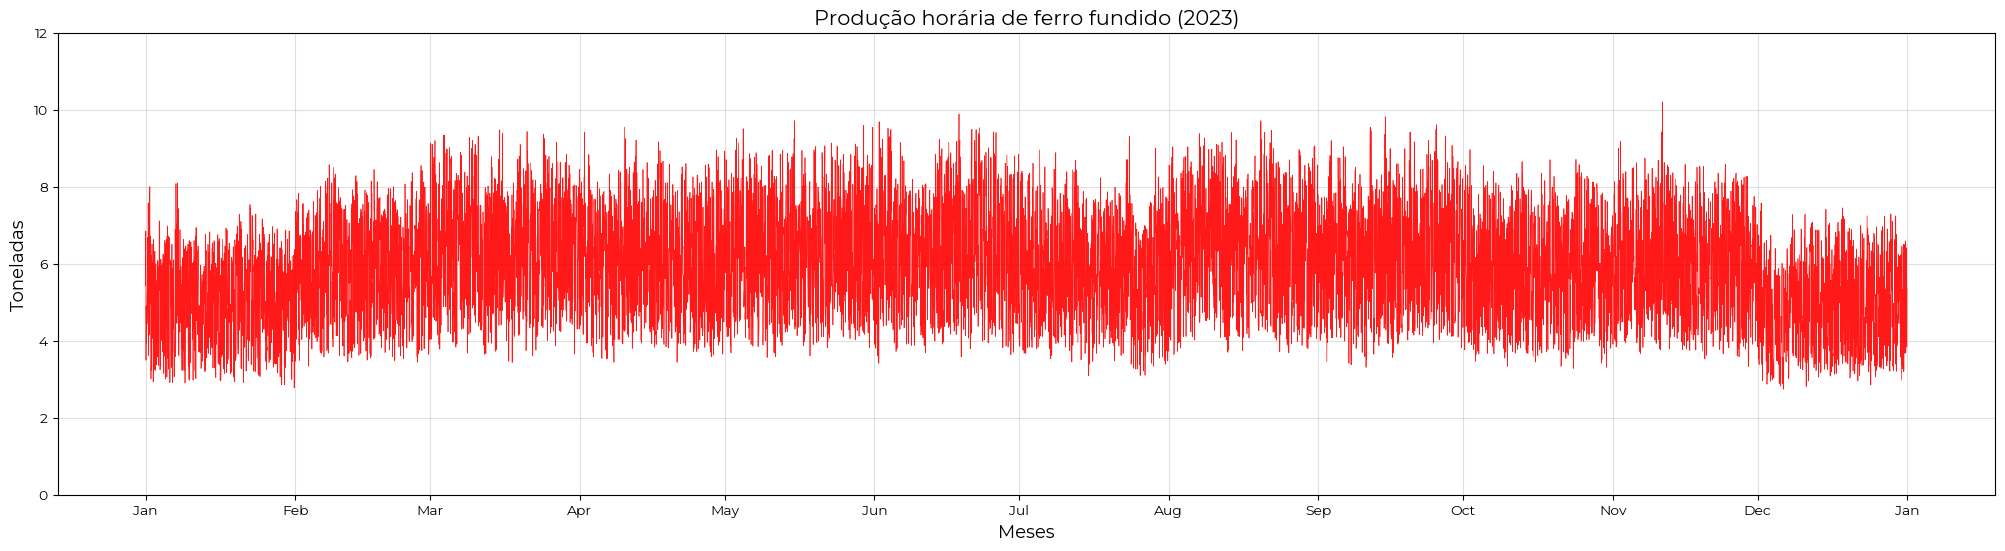

,Data,Ferro (t)
0,2023-01-01 00:00:00,5.433916
1,2023-01-01 01:00:00,6.846161
2,2023-01-01 02:00:00,3.492701
3,2023-01-01 03:00:00,4.899897
4,2023-01-01 04:00:00,4.175497
...,...,...
8755,2023-12-31 19:00:00,5.049236
8756,2023-12-31 20:00:00,5.042059
8757,2023-12-31 21:00:00,6.415279
8758,2023-12-31 22:00:00,3.836878


In [28]:
numpy.random.seed(1)
hourly_production = numpy.arange(numpy.datetime64('2023-01-01'),numpy.datetime64('2024-01-01'),numpy.timedelta64(1,'h'))
hourly_production = pandas.DataFrame(hourly_production)
hourly_production = hourly_production.rename(columns={0:'Data'})
hourly_production['Dia'] = hourly_production.Data.dt.day
hourly_production['Hora'] = hourly_production.Data.dt.hour

#Laço para aplicação do Método Monte-Carlo na sazonalidade horária
fluct2 = []
for i in range(len(daily_production)):
    atv_diaria = daily_production['Ferro (t)'][i]
    dataMean = atv_diaria/24
    data = numpy.random.rand(24)
    dataMax = 1.4*dataMean
    dataMin = 0.6*dataMean
    hourly_values = (dataMax - dataMin)*data + dataMin
    hourly_values[hourly_values < 0] = 0
    scale_factor = atv_diaria/numpy.sum(hourly_values)
    fluct2.extend(scale_factor*hourly_values)

hourly_production['Ferro (t)'] = fluct2
hourly_production.to_csv(f'{root}/results/variabilidade_atv.csv')

#Plotagem dos resultados
plt.figure(figsize=(25,6))
plt.plot(hourly_production.Data,hourly_production['Ferro (t)'],color='red',alpha=0.9,linewidth=0.5)
plt.title('Produção horária de ferro fundido (2023)', fontsize=15)
plt.xlabel('Meses', fontsize=13)
plt.ylabel('Toneladas', fontsize=13)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.grid(alpha=0.4)
plt.ylim(top=12,bottom=0)
plt.show()
hourly_production[['Data','Ferro (t)']]

A taxa de atividade horária máxima, média e mínima podem ser visualizadas a seguir. Observa-se que não há números negativos de produção e que a empresa produz 24 horas sem interrupção ao longo do ano de 2023.

In [8]:
print(f'Produção Horária Mínima: {hourly_production["Ferro (t)"].min() :.2f} toneladas')
print(f'Produção Horária Média: {hourly_production["Ferro (t)"].mean() :.2f} toneladas')
print(f'Produção Horária Máxima: {hourly_production["Ferro (t)"].max() :.2f} toneladas')
print(f'Produção Horária Mediana: {hourly_production["Ferro (t)"].median() :.2f} toneladas')

Produção Horária Mínima: 2.74 toneladas
Produção Horária Média: 5.94 toneladas
Produção Horária Máxima: 10.20 toneladas
Produção Horária Mediana: 5.89 toneladas


A soma de todas as produções horarias, diárias ou mensais devem ser igual a a 52 mil toneladas produzidas anualmente pela Embraco.

In [9]:
print(f"Produção Mensal Total de Ferro Fundido: {round(monthly_production['Ferro (t)'].sum(), 3)} toneladas")
print(f"Produção Diária Total de Ferro Fundido: {round(daily_production['Ferro (t)'].sum(), 3)} toneladas")
print(f"Produção Horária Total de Ferro Fundido: {round(hourly_production['Ferro (t)'].sum(), 3)} toneladas")

Produção Mensal Total de Ferro Fundido: 52000.0 toneladas
Produção Diária Total de Ferro Fundido: 52000.0 toneladas
Produção Horária Total de Ferro Fundido: 52000.0 toneladas


##### **Estimativa das emissões**

A emissão é o produto entre a taxa de execução da atividade e o fator de emissão característico da atividade. Com base na taxa de atividade horária previamente estabelecida para a fundição de ferro da empresa Embraco, é possível realizar estimativas da quantidade de poluentes emitidos para cada período horário discretizado ao longo do ano de 2023.

In [10]:
#Selecionando os dados de produção por hora
emission = hourly_production[['Data','Ferro (t)']]

#Calculando a quantidade de poluentes emitidos para cada processo da empresa
for i in list(emission_factor.columns):
    for j in list(emission_factor.index):
        if emission_factor.loc[j,i] != 0:
            factor = float(emission_factor.loc[j,i])
            emission[f'{i} - {j} (kg)'] = emission['Ferro (t)']*factor

rounded_emission = round(emission.head(5), 2)
rounded_emission

,Data,Ferro (t),PM - Forno elétrico a arco (kg),PM - Aquecimento de sucata e carga (kg),PM - Tratamento com magnésio (kg),PM - Limpeza e finalização (kg),PM - Fabricação e cozimento de núcleo (kg),CO - Forno elétrico a arco (kg),NO3 - Forno elétrico a arco (kg),COVs - Forno elétrico a arco (kg)
0,2023-01-01 00:00:00,5.43,34.23,0.54,1.09,0.27,3.26,103.24,1.63,0.82
1,2023-01-01 01:00:00,6.85,43.13,0.68,1.37,0.34,4.11,130.08,2.05,1.03
2,2023-01-01 02:00:00,3.49,22.00,0.35,0.70,0.17,2.10,66.36,1.05,0.52
3,2023-01-01 03:00:00,4.90,30.87,0.49,0.98,0.24,2.94,93.10,1.47,0.73
4,2023-01-01 04:00:00,4.18,26.31,0.42,0.84,0.21,2.51,79.33,1.25,0.63


**Estimativa das taxas de emissões**

Agora, devemos transformar os fatores de emissão, expressos em kilogramas de poluente por tonelada de ferro cinzento fundido, para gramas de poluente por tonelada de ferro cinzendo fundido, a fim de calcular as taxas de emissão dos processos da Embraco em <i>**gramas por segundo**</i>. Ao expressar as emissões em gramas por segundo, podemos ter uma compreensão mais precisa e granular da quantidade de poluentes liberados em determinados momentos.

In [11]:
emission_factor2 = emission_factor*1000
emission_factor2

,PM,CO,NO3,COVs
Processos,,,,
Forno elétrico a arco,6300.0,19000.0,300.0,150.0
Aquecimento de sucata e carga,100.0,0.0,0.0,0.0
Tratamento com magnésio,200.0,0.0,0.0,0.0
Limpeza e finalização,50.0,0.0,0.0,0.0
Fabricação e cozimento de núcleo,600.0,0.0,0.0,0.0


Após calcular a quantidade de poluentes emitidos com base na taxa de atividade horária, é possível determinar a taxa para cada intervalo de tempo ao dividir a massa de poluentes pelo número de segundos (3600s) no horário considerado.

In [12]:
emission_rate = hourly_production[['Data','Ferro (t)']]

#Calculando a quantidade de poluentes emitidos por segundo para cada processo da empresa
for i in list(emission_factor2.columns):
    for j in list(emission_factor2.index):
        if emission_factor2.loc[j,i] != 0:
            factor = float(emission_factor2.loc[j,i])
            emission_rate[f'{i} - {j} (g/s)'] = emission_rate['Ferro (t)']*factor/3600

rounded_emission_rate = round(emission_rate.tail(5),2)
rounded_emission_rate

,Data,Ferro (t),PM - Forno elétrico a arco (g/s),PM - Aquecimento de sucata e carga (g/s),PM - Tratamento com magnésio (g/s),PM - Limpeza e finalização (g/s),PM - Fabricação e cozimento de núcleo (g/s),CO - Forno elétrico a arco (g/s),NO3 - Forno elétrico a arco (g/s),COVs - Forno elétrico a arco (g/s)
8755,2023-12-31 19:00:00,5.05,8.84,0.14,0.28,0.07,0.84,26.65,0.42,0.21
8756,2023-12-31 20:00:00,5.04,8.82,0.14,0.28,0.07,0.84,26.61,0.42,0.21
8757,2023-12-31 21:00:00,6.42,11.23,0.18,0.36,0.09,1.07,33.86,0.53,0.27
8758,2023-12-31 22:00:00,3.84,6.71,0.11,0.21,0.05,0.64,20.25,0.32,0.16
8759,2023-12-31 23:00:00,5.37,9.40,0.15,0.30,0.07,0.89,28.33,0.45,0.22


##### **Resultados**

No presente estudo, foi previamente identificado que o processo de maior emissão de poluentes na fundição de ferro da Embraco é o **forno elétrico a arco**. Durante o funcionamento do forno elétrico a arco, ocorre a fusão de materiais metálicos através de um arco elétrico gerado entre eletrodos, resultando na liberação de gases e partículas que podem conter substâncias poluentes. A natureza desses poluentes pode variar, mas muitas vezes incluem compostos prejudiciais como óxidos de nitrogênio e material particulado fino. As taxas de emissão máxima, média e mínima podem ser visualizadas na tabela abaixo:

In [13]:
estatistics = round(emission_rate.agg(['max', 'min', 'mean']),2).drop(['Data','Ferro (t)'],axis=1)
estatistics

,PM - Forno elétrico a arco (g/s),PM - Aquecimento de sucata e carga (g/s),PM - Tratamento com magnésio (g/s),PM - Limpeza e finalização (g/s),PM - Fabricação e cozimento de núcleo (g/s),CO - Forno elétrico a arco (g/s),NO3 - Forno elétrico a arco (g/s),COVs - Forno elétrico a arco (g/s)
max,17.85,0.28,0.57,0.14,1.70,53.85,0.85,0.43
min,4.80,0.08,0.15,0.04,0.46,14.46,0.23,0.11
mean,10.39,0.16,0.33,0.08,0.99,31.33,0.49,0.25


As taxas de emissão máxima, média e mínima para cada poluente, considerando a soma de todos os processos envolvidos, são apresentadas na tabela abaixo. Nota-se que o **monóxido de carbono** é o principal poluente liberado na atmosfera pela fundição de ferro da empresa Embraco, destacando-se pelas suas taxas de emissão mais elevadas.

In [14]:
estatistics2 = pandas.DataFrame()
columns = []

for i in list(emission_factor2.columns):
    selected = emission_rate.filter(like=f'{str(i)} -')
    columns.append(f'{i} (g/s)')
    selected[f'{i} (g/s)'] = selected.sum(axis=1)
    estatistics2 = pandas.concat([estatistics2,selected],axis=1)

estatistics2 = estatistics2[columns]
estatistics2['Data'] = emission_rate['Data']
estatistics2 = estatistics2.reset_index(drop=True).set_index('Data')
estatistics2 = round(estatistics2.agg(['max', 'min', 'mean','std']),2)
estatistics2

,PM (g/s),CO (g/s),NO3 (g/s),COVs (g/s)
max,20.55,53.85,0.85,0.43
min,5.52,14.46,0.23,0.11
mean,11.95,31.33,0.49,0.25
std,2.93,7.69,0.12,0.06


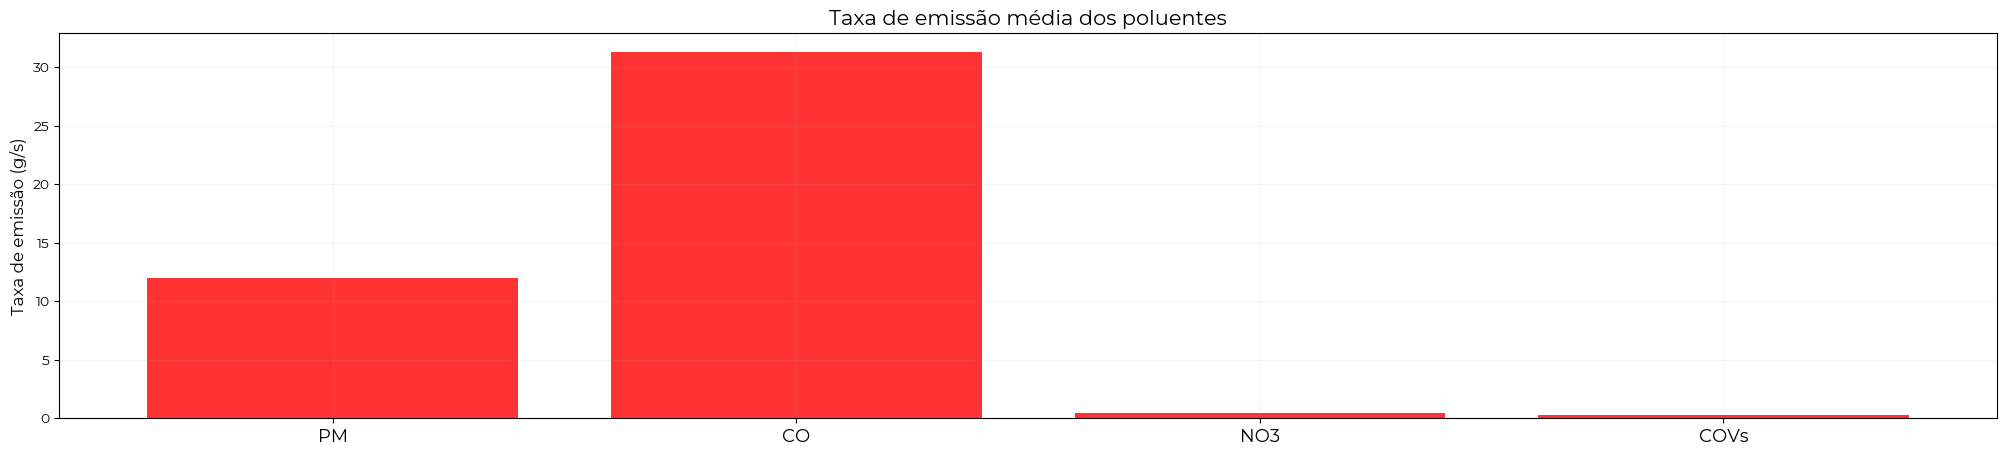

In [29]:
#Plotagem do gráfico
plt.rc('font',family='Montserrat')
plt.figure(figsize=(25,5))
plt.bar(estatistics2.columns,estatistics2.loc['mean',:], color='red',alpha=0.8)
plt.title('Taxa de emissão média dos poluentes',fontsize=15)
plt.ylabel('Taxa de emissão (g/s)',fontsize=12)
plt.xticks(numpy.arange(len(emission_factor2.columns)), list(emission_factor.columns),fontsize=13)
plt.grid(alpha=0.1)
plt.show()

A seguir estão os gráficos da taxa de emissão para cada poluente, considerando os diferentes processos envolvidos na fundição de ferro.

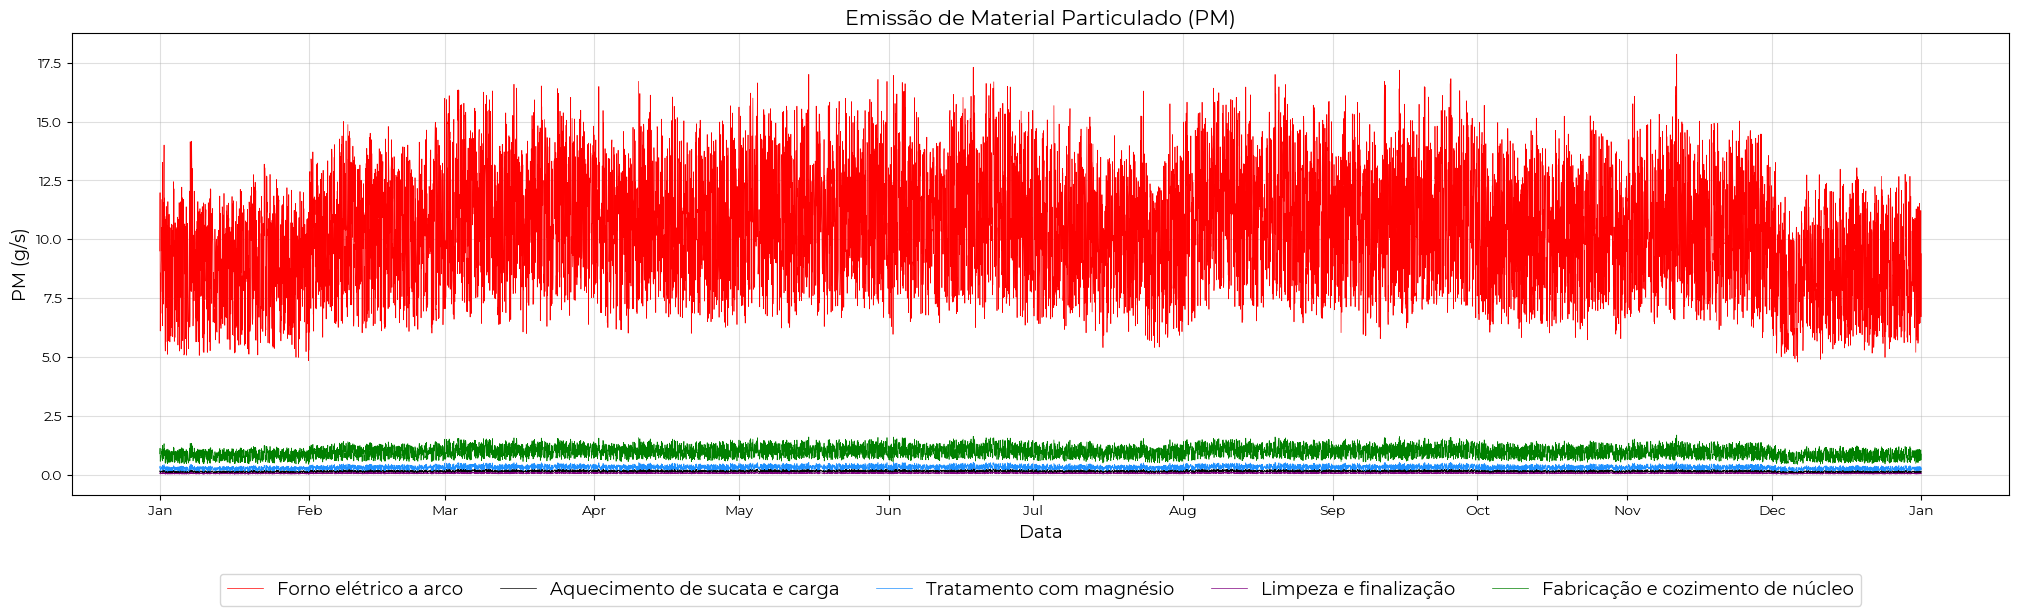

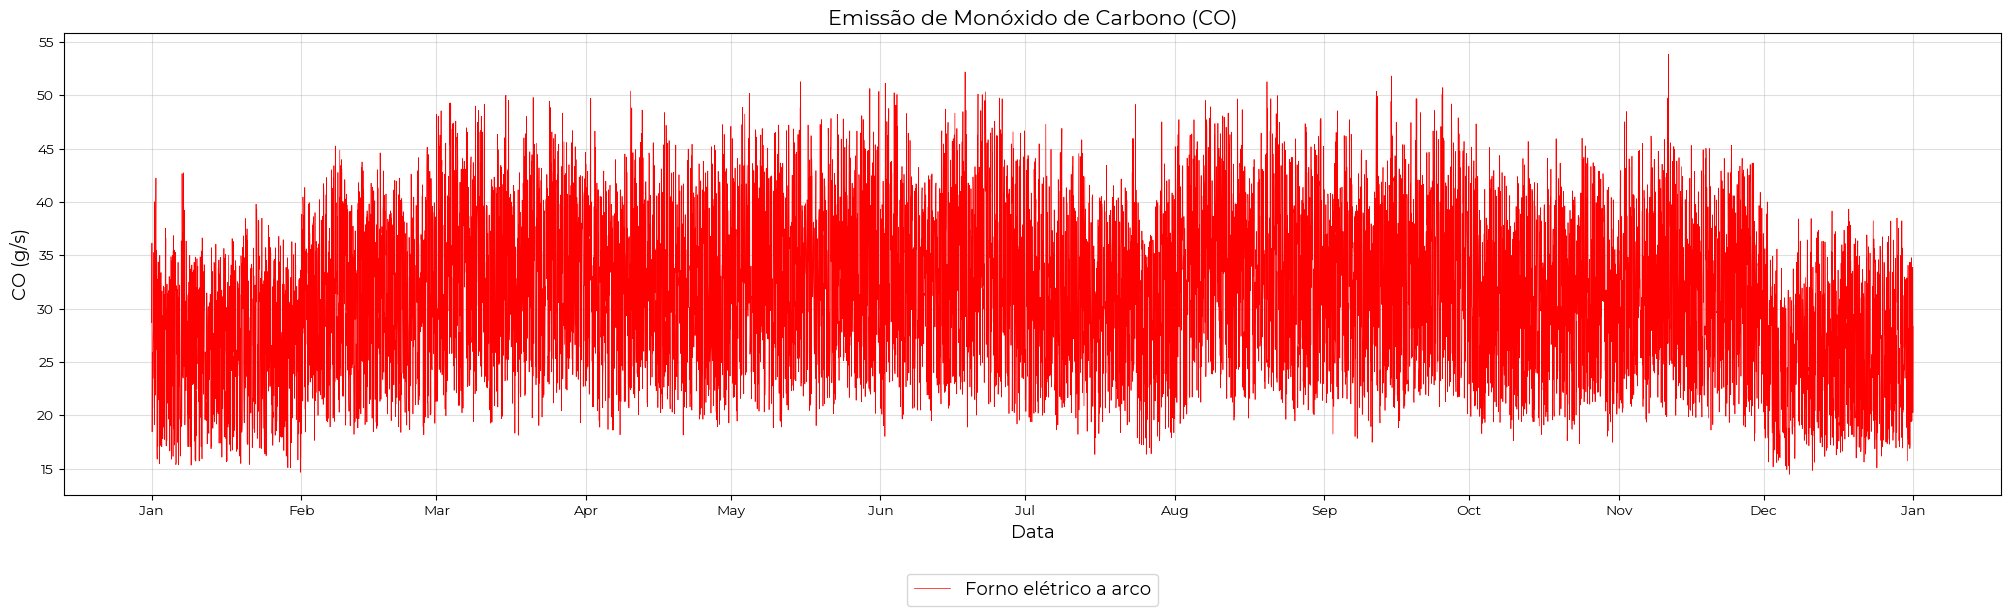

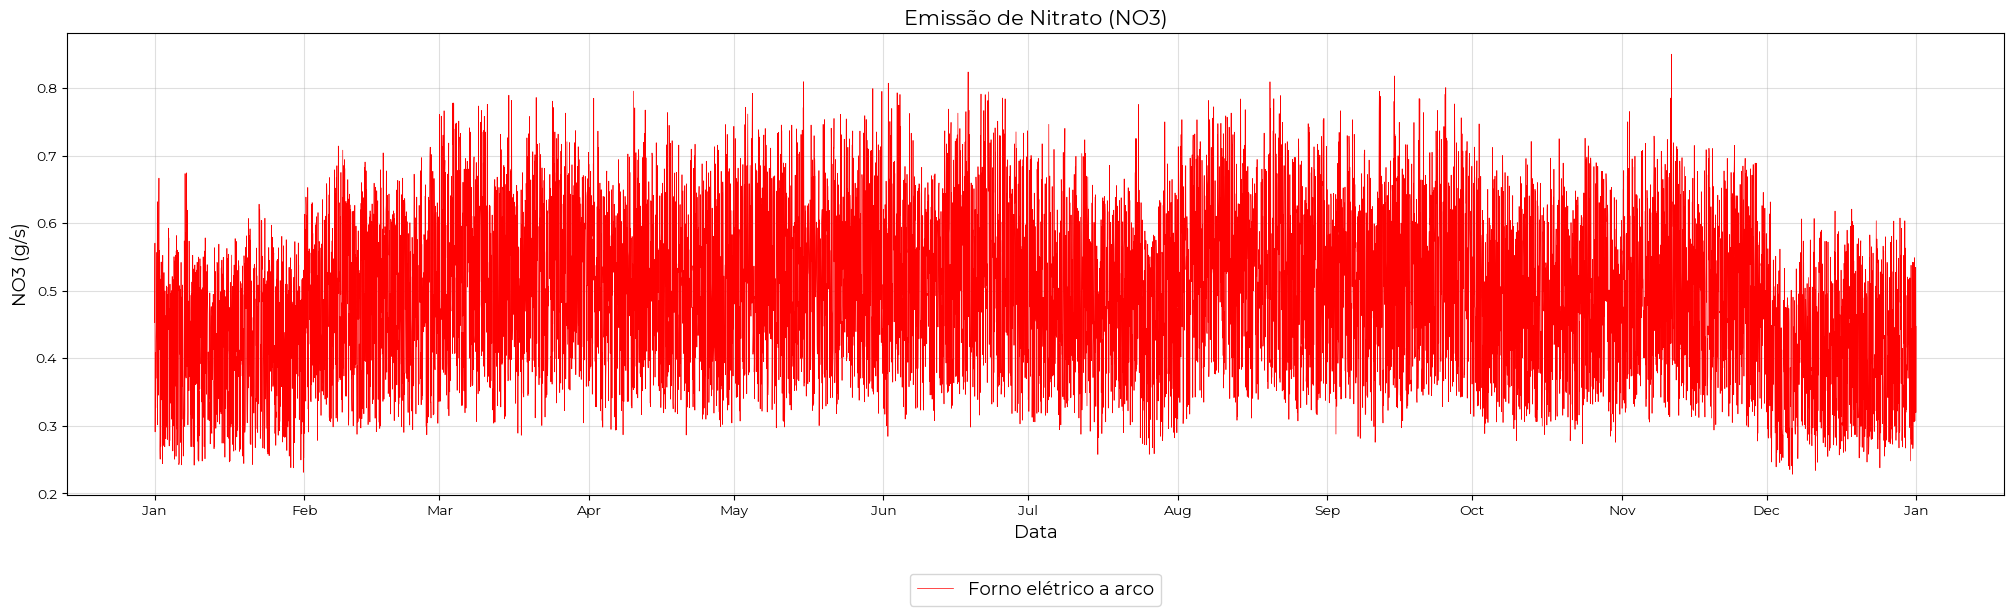

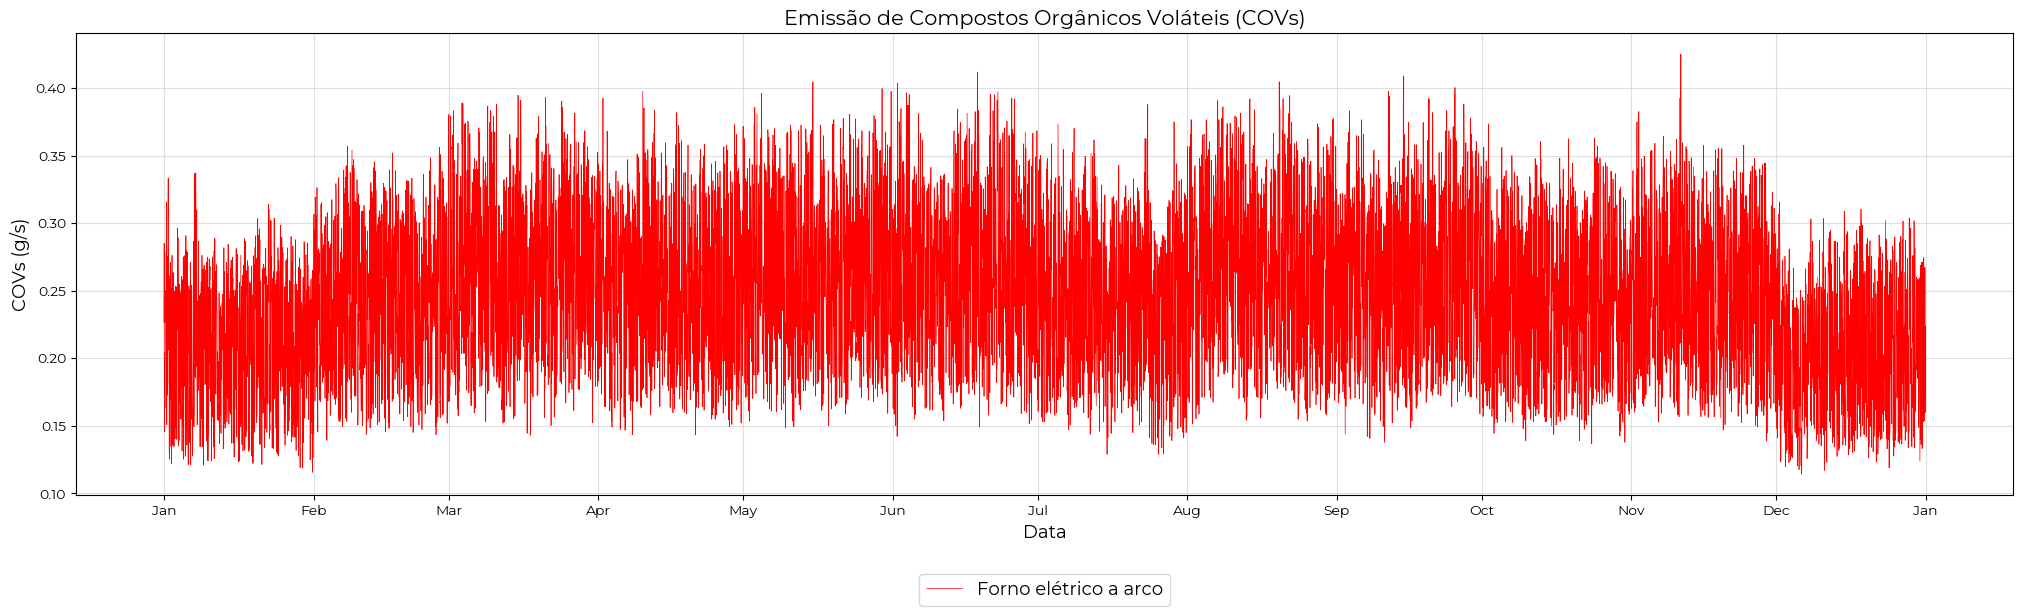

In [30]:
#Dicionário de palavras para fazer uma troca pelos códigos de emissão
translate = {'PM':'Material Particulado','CO': 'Monóxido de Carbono', 'NO3':'Nitrato', 'COVs':'Compostos Orgânicos Voláteis'}
colors = ['red','black','dodgerblue','purple','green']

for i in list(emission_factor2.columns):
    selected = emission_rate.filter(like=f'{str(i)} -')
    selected['Data'] = emission_rate['Data']
    selected = selected.reset_index(drop=True).set_index('Data')
    colunas = list(selected.columns)

    #Plotagem do gráfico
    fig,ax = plt.subplots(figsize=(25,6))
    ax.set_title(f'Emissão de {translate[i]} ({i})', fontsize=15)
    ax.set_xlabel('Data', fontsize=13)
    ax.set_ylabel(f'{i} (g/s)', fontsize=13)
    ax.grid(alpha=0.4)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
    k = 0
    for j in colunas:
        ax.plot(selected.index,selected[j],color=colors[k],linewidth=0.5,label=list(emission_factor2.index)[k])
        k+=1
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, -0.15),ncol=5,fontsize=13)